Code copied from https://repo.ops.maap-project.org/gchang/gedi_tutorials/-/blob/main/2_gedi_l4a_subsets.ipynb

From Laura:
- Select only variables of user interest (e.g. RH100, RH50 from L2A, cover and pan from L2B, agbd and agbd_se from L4A)
- Ability to subset by sensitivity attribute to some level (e.g. where sensitivity >0.95)
- Ability to subset using quality flag (L4_quality_flag in L4A, quality_flag in L2A)


In [36]:
import os
from glob import glob
from os import path
import pandas as pd
import geopandas as gpd
import h5py
import numpy as np
from profilehooks import timecall
from typing import List

from gedi_utils import get_geo_boundary

In [43]:
infile = "GEDI04_A_2019108045816_O01962_01_T01066_02_002_01_V002.h5"
hf_in = h5py.File(infile, 'r')

In [72]:
@timecall
def subset_gedi_granule(granule: str, aoi, filter_cols: List = ["lat_lowestmode", "lon_lowestmode"]):
    """
    Subset a GEDI granule by a polygon in CRS 4326
    granule = path to a granule h5 file that's already been downloaded
    aoi = a shapely polygon of the aoi
    
    return path to geojson output
    """
    infile = granule

    hf_in = h5py.File(infile, 'r')
    subset_df = pd.DataFrame()
    
    # loop through BEAMXXXX groups
    for v in list(hf_in.keys()):
        if v.startswith('BEAM'):
            col_names = []
            col_val = []
            beam = hf_in[v]
            
            # find the shots that overlays the area of interest (GRSM)
            #lat = beam['lat_lowestmode'][:]
            #lon = beam['lon_lowestmode'][:]
            #i = np.arange(0, len(lat), 1) # index
            #geo_arr = list(zip(lat,lon, i))
            #l4adf = pd.DataFrame(geo_arr, columns=["lat_lowestmode", "lon_lowestmode", "i"])
            #l4agdf = gpd.GeoDataFrame(l4adf, geometry=gpd.points_from_xy(l4adf.lon_lowestmode, l4adf.lat_lowestmode))
            #l4agdf.crs = "EPSG:4326"
            #l4agdf_gsrm = l4agdf[l4agdf['geometry'].within(grsm_epsg4326.geometry[0])]  
            #indices = l4agdf_gsrm.i
            
            
            # TODO: when to spatial subset?
            for key, value in beam.items():
                # looping through subgroups
                if isinstance(value, h5py.Group):
                    for key2, value2 in value.items():
                        if (key2 not in filter_cols):
                            continue
                        if (key2 != "shot_number"):
                             # xvar variables have 2D
                            if (key2.startswith('xvar')):
                                for r in range(4):
                                    col_names.append(key2 + '_' + str(r+1))
                                    col_val.append(value2[:, r].tolist())
                            else:
                                col_names.append(key2)
                                col_val.append(value2[:].tolist())
                
                #looping through base group
                else:
                    if (key not in filter_cols):
                        continue
                    # xvar variables have 2D
                    if (key.startswith('xvar')):
                        for r in range(4):
                            col_names.append(key + '_' + str(r+1))
                            col_val.append(value[:, r].tolist())
                           
                    else:
                        col_names.append(key)
                        col_val.append(value[:].tolist())
                    
            # create a pandas dataframe        
            beam_df = pd.DataFrame(map(list, zip(*col_val)), columns=col_names) 
            # Inserting BEAM names
            beam_df.insert(0, 'BEAM', np.repeat(str(v), len(beam_df.index)).tolist())
            # Appending to the subset_df dataframe
            subset_df = subset_df.append(beam_df)
    
    hf_in.close()
    # all_gdf = gpd.GeoDataFrame(subset_df, geometry=gpd.points_from_xy(subset_df.lon_lowestmode, subset_df.lat_lowestmode))
    all_gdf = gpd.GeoDataFrame(subset_df.loc[:,~subset_df.columns.isin(['lon_lowestmode', 'lat_lowestmode'])],
                               geometry=gpd.points_from_xy(subset_df.lon_lowestmode, subset_df.lat_lowestmode))
    all_gdf.crs = "EPSG:4326"
    # TODO: Drop the lon and lat columns after geometry creation(or during)
    # TODO: document how many points before and after filtering
    print(f"All points {all_gdf.shape}")
    subset_gdf = all_gdf[all_gdf['geometry'].within(aoi.geometry[0])] 
    print(f"Subset points {subset_gdf.shape}")
    
    return subset_gdf

@timecall
def write_subset(infile, gdf):
    """
    Write GeoDataFrame to geojson
    """
    outfile = infile.replace('.h5', '.fgb')
    gdf.to_file(outfile, driver='FlatGeobuf')
    
    return outfile

In [38]:
gabon_gdf = get_geo_boundary('GAB', 0)

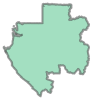

In [39]:
gabon_gdf.geometry[0]

In [73]:
#test = subset_gedi_granule(infile, gabon_gdf)
# Filtered version
filter_cols = ["agbd", "agbd_se", "l4_quality_flag", "sensitivity", "lat_lowestmode", "lon_lowestmode"]
test = subset_gedi_granule(infile, gabon_gdf, filter_cols)

All points (510801, 6)



  subset_gedi_granule (/tmp/ipykernel_12978/602969250.py:1):
    46.652 seconds



Subset points (64209, 6)


In [74]:
print(test.shape)
test.head()

(64209, 6)


,BEAM,agbd,agbd_se,l4_quality_flag,sensitivity,geometry
55637,BEAM0000,-9999.0,-9999.0,0,-0.642939,POINT (10.58764 -3.29189)
55638,BEAM0000,-9999.0,-9999.0,0,8.097681,POINT (10.58794 -3.29146)
55639,BEAM0000,-9999.0,-9999.0,0,-252.114624,POINT (10.58824 -3.29104)
55640,BEAM0000,-9999.0,-9999.0,0,-1.101499,POINT (10.58854 -3.29062)
55641,BEAM0000,-9999.0,-9999.0,0,3.414868,POINT (10.58884 -3.29020)


In [27]:
# Reduce to a set of preselect columns
# TODO: it would be better to not even include in the dataframe to start
filter_strings = ["agbd", "agbd_se", "l4_quality_flag", "sensitivity", "geometry"]
cols = list(test.columns)
def Filter(string, substr):
    return [str for str in string if
             any(sub in str for sub in substr)]

final_table_columns = Filter(cols, filter_strings)
#test.drop(columns=test.columns.difference(final_table_columns), inplace=True)
test.drop(columns=test.columns.difference(filter_strings), inplace=True)

In [75]:
write_subset(infile, test)


  write_subset (/tmp/ipykernel_12978/602969250.py:85):
    5.963 seconds



'GEDI04_A_2019108045816_O01962_01_T01066_02_002_01_V002.fgb'

In [ ]:
# Alternate method using pandas or xarray?
pd_h5 = pd.read_hdf(infile, )

In [16]:
import fiona 
fiona.supported_drivers

{'ARCGEN': 'r',
 'DXF': 'rw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'FlatGeobuf': 'rw',
 'GeoJSON': 'raw',
 'GeoJSONSeq': 'rw',
 'GPKG': 'raw',
 'GML': 'rw',
 'OGR_GMT': 'rw',
 'GPX': 'rw',
 'GPSTrackMaker': 'rw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'OGR_PDS': 'r',
 'S57': 'r',
 'SQLite': 'raw',
 'TopoJSON': 'r'}

In [16]:
filter_strings = ["agbd", "l4_quality_flag", "sensitivity"]
cols = list(test.columns)
def Filter(string, substr):
    return [str for str in string if
             any(sub in str for sub in substr)]
Filter(cols, filter_strings)

['agbd',
 'agbd_pi_lower',
 'agbd_pi_upper',
 'agbd_a1',
 'agbd_a10',
 'agbd_a2',
 'agbd_a3',
 'agbd_a4',
 'agbd_a5',
 'agbd_a6',
 'agbd_pi_lower_a1',
 'agbd_pi_lower_a10',
 'agbd_pi_lower_a2',
 'agbd_pi_lower_a3',
 'agbd_pi_lower_a4',
 'agbd_pi_lower_a5',
 'agbd_pi_lower_a6',
 'agbd_pi_upper_a1',
 'agbd_pi_upper_a10',
 'agbd_pi_upper_a2',
 'agbd_pi_upper_a3',
 'agbd_pi_upper_a4',
 'agbd_pi_upper_a5',
 'agbd_pi_upper_a6',
 'agbd_se_a1',
 'agbd_se_a10',
 'agbd_se_a2',
 'agbd_se_a3',
 'agbd_se_a4',
 'agbd_se_a5',
 'agbd_se_a6',
 'agbd_t_a1',
 'agbd_t_a10',
 'agbd_t_a2',
 'agbd_t_a3',
 'agbd_t_a4',
 'agbd_t_a5',
 'agbd_t_a6',
 'agbd_t_pi_lower_a1',
 'agbd_t_pi_lower_a10',
 'agbd_t_pi_lower_a2',
 'agbd_t_pi_lower_a3',
 'agbd_t_pi_lower_a4',
 'agbd_t_pi_lower_a5',
 'agbd_t_pi_lower_a6',
 'agbd_t_pi_upper_a1',
 'agbd_t_pi_upper_a10',
 'agbd_t_pi_upper_a2',
 'agbd_t_pi_upper_a3',
 'agbd_t_pi_upper_a4',
 'agbd_t_pi_upper_a5',
 'agbd_t_pi_upper_a6',
 'agbd_t_se_a1',
 'agbd_t_se_a10',
 'agbd_t_s

In [34]:
folder_path = '/projects/my-public-bucket/gedi-l4a/gabon'
file_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('h5')]
file_list

['/projects/my-public-bucket/gedi-l4a/gabon/GEDI04_A_2019108045816_O01962_01_T01066_02_002_01_V002.h5',
 '/projects/my-public-bucket/gedi-l4a/gabon/GEDI04_A_2019108045816_O01962_02_T01066_02_002_01_V002.h5',
 '/projects/my-public-bucket/gedi-l4a/gabon/GEDI04_A_2019110154024_O02000_04_T04761_02_002_01_V002.h5',
 '/projects/my-public-bucket/gedi-l4a/gabon/GEDI04_A_2019111040155_O02008_01_T04616_02_002_01_V002.h5',
 '/projects/my-public-bucket/gedi-l4a/gabon/GEDI04_A_2019111040155_O02008_02_T04616_02_002_01_V002.h5',
 '/projects/my-public-bucket/gedi-l4a/gabon/GEDI04_A_2019111145043_O02015_03_T00201_02_002_01_V002.h5',
 '/projects/my-public-bucket/gedi-l4a/gabon/GEDI04_A_2019111145043_O02015_04_T00201_02_002_01_V002.h5',
 '/projects/my-public-bucket/gedi-l4a/gabon/GEDI04_A_2019112031214_O02023_01_T02902_02_002_01_V002.h5',
 '/projects/my-public-bucket/gedi-l4a/gabon/GEDI04_A_2019114135421_O02061_03_T00905_02_002_01_V002.h5',
 '/projects/my-public-bucket/gedi-l4a/gabon/GEDI04_A_20191141354

In [59]:
# For testing subset the 10 sample granules
for file in file_list:
    filter_strings = ["agbd", "agbd_se", "l4_quality_flag", "sensitivity", "lat_lowestmode", "lon_lowestmode"]
    subset = subset_gedi_granule(file, gabon_gdf, filter_strings)
    #cols = list(subset.columns)
    #final_table_columns = Filter(cols, filter_strings)
    #final_table_columns = filter_strings
    #subset.drop(columns=test.columns.difference(final_table_columns), inplace=True)
    if subset.shape[0] > 0 :
        write_subset(file, subset)


All points (510801, 8)



  subset_gedi_granule (/tmp/ipykernel_12978/815998746.py:1):
    46.730 seconds



Subset points (64209, 8)



  write_subset (/tmp/ipykernel_12978/815998746.py:82):
    8.495 seconds



All points (1338484, 8)
Subset points (24866, 8)



  subset_gedi_granule (/tmp/ipykernel_12978/815998746.py:1):
    27.611 seconds


  write_subset (/tmp/ipykernel_12978/815998746.py:82):
    3.922 seconds



All points (609748, 8)



  subset_gedi_granule (/tmp/ipykernel_12978/815998746.py:1):
    5.021 seconds



Subset points (0, 8)
All points (395012, 8)



  subset_gedi_granule (/tmp/ipykernel_12978/815998746.py:1):
    13.178 seconds



Subset points (1846, 8)



  write_subset (/tmp/ipykernel_12978/815998746.py:82):
    1.736 seconds



All points (1338733, 8)
Subset points (14567, 8)



  subset_gedi_granule (/tmp/ipykernel_12978/815998746.py:1):
    33.706 seconds


  write_subset (/tmp/ipykernel_12978/815998746.py:82):
    2.952 seconds



All points (1037928, 8)



  subset_gedi_granule (/tmp/ipykernel_12978/815998746.py:1):
    33.965 seconds



Subset points (39284, 8)



  write_subset (/tmp/ipykernel_12978/815998746.py:82):
    5.866 seconds



All points (515477, 8)



  subset_gedi_granule (/tmp/ipykernel_12978/815998746.py:1):
    29.621 seconds



Subset points (37779, 8)



  write_subset (/tmp/ipykernel_12978/815998746.py:82):
    5.283 seconds



All points (522780, 8)



  subset_gedi_granule (/tmp/ipykernel_12978/815998746.py:1):
    22.457 seconds



Subset points (0, 8)
All points (1045559, 8)



  subset_gedi_granule (/tmp/ipykernel_12978/815998746.py:1):
    15.608 seconds



Subset points (0, 8)
All points (912543, 8)
Subset points (66053, 8)



  subset_gedi_granule (/tmp/ipykernel_12978/815998746.py:1):
    48.031 seconds


  write_subset (/tmp/ipykernel_12978/815998746.py:82):
    9.183 seconds



All points (508165, 8)



  subset_gedi_granule (/tmp/ipykernel_12978/815998746.py:1):
    46.880 seconds



Subset points (58430, 8)



  write_subset (/tmp/ipykernel_12978/815998746.py:82):
    7.914 seconds



All points (1338521, 8)



  subset_gedi_granule (/tmp/ipykernel_12978/815998746.py:1):
    33.797 seconds



Subset points (23275, 8)



  write_subset (/tmp/ipykernel_12978/815998746.py:82):
    3.834 seconds



All points (1054709, 8)



  subset_gedi_granule (/tmp/ipykernel_12978/815998746.py:1):
    11.281 seconds



Subset points (0, 8)
All points (372346, 8)



  subset_gedi_granule (/tmp/ipykernel_12978/815998746.py:1):
    6.934 seconds



Subset points (0, 8)


In [50]:
for k,v in hf_in["BEAM0000"].items():
    if (k not in filter_cols):
        continue
    else:
        print(k)
        print(v)

agbd
<HDF5 dataset "agbd": shape (63659,), type "<f4">
agbd_se
<HDF5 dataset "agbd_se": shape (63659,), type "<f4">
l4_quality_flag
<HDF5 dataset "l4_quality_flag": shape (63659,), type "|u1">
lat_lowestmode
<HDF5 dataset "lat_lowestmode": shape (63659,), type "<f8">
lon_lowestmode
<HDF5 dataset "lon_lowestmode": shape (63659,), type "<f8">
sensitivity
<HDF5 dataset "sensitivity": shape (63659,), type "<f4">


In [67]:
#df.loc[:, ~df.columns.isin(['rebounds', 'assists'])]
test.loc[:,~test.columns.isin(['lon_lowestmode', 'lat_lowestmode'])].columns

test2 = gpd.GeoDataFrame(test.loc[:,~test.columns.isin(['lon_lowestmode', 'lat_lowestmode', 'geometry'])], 
                         geometry=gpd.points_from_xy(test.lon_lowestmode, test.lat_lowestmode))

In [68]:
test2.head()

,BEAM,agbd,agbd_se,l4_quality_flag,sensitivity,geometry
55637,BEAM0000,-9999.0,-9999.0,0,-0.642939,POINT (10.58764 -3.29189)
55638,BEAM0000,-9999.0,-9999.0,0,8.097681,POINT (10.58794 -3.29146)
55639,BEAM0000,-9999.0,-9999.0,0,-252.114624,POINT (10.58824 -3.29104)
55640,BEAM0000,-9999.0,-9999.0,0,-1.101499,POINT (10.58854 -3.29062)
55641,BEAM0000,-9999.0,-9999.0,0,3.414868,POINT (10.58884 -3.29020)
